# Cross-resonance gate between a transmon and a fluxonium: driving fluxonium

In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [1]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem, Qubit
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import weyl_by_index, pauli_by_index
from pysqkit.solvers import solvkit
from pysqkit.drives.pulse_shapes import gaussian_top
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json
import cmath
import util_tf_cr

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_T + H^{(0)}_F + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_T \hat{q}_T + \varepsilon_F \hat{q}_F \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $Z X$ term in the Hamiltonian. In particular, we will explore the idea of driving the fluxonium at the transmon frequency. The opposite idea to drive the transmon at the fluxonium frequency does not seem that promising. However, one might evaluate using Raman transitions.

# Introducing the qubits and the coupled system

In [2]:
with open('../flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [3]:
temperature = 0.020 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "3"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq= 4.5, #parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"],
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"],  
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], 
    env_thermal_energy=thermal_energy,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]
flx_freq_03 = flx.eig_energies(4)[3] - flx.eig_energies(4)[0]
flx_freq_12 = flx.eig_energies(4)[2] - flx.eig_energies(4)[1]
flx_freq_04 = flx.eig_energies(5)[4] - flx.eig_energies(4)[0]
#flx_freq_05 = flx.eig_energies(6)[5] - flx.eig_energies(6)[0]

In [4]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

The basis principle behind the gate is illustrated in the following figure

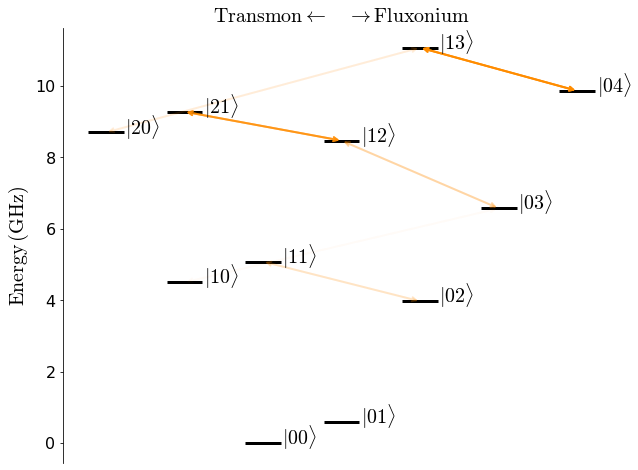

In [5]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util_tf_cr.energy_levels_diagram(bare_system, level_list, show_drive=False)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. 
We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\mu_{YZ} = \lvert \langle 10 | q_{F} | 00 \rangle - \langle 11 | q_{F} |01 \rangle \rvert $$
$$\mu_{Y} = \lvert \langle 10 | q_{F} | 00 \rangle + \langle 11 | q_{F} |01 \rangle \rvert $$

The second term quantifies the gate speed. Notice that if the phase of the drive is $0$ one hase a $YZ$ term from the charge operator. 

For the given parameters we have

In [6]:
# The following functions can also be found in the util_tf_cr.py file and are here reported for clarity
# of the notebook

def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def mu_yz_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2*eps/2

def mu_zy_transm(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the transmon
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['01'])
    yz1 = get_mat_elem(op, comp_states['10'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the direct drive on the transmon numerically in the dressed basis 
    when driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2*eps/2

def mu_yz_flx_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float,
    eps: float
):
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient via the second order Schrieffer-Wolff
    transformation
    """
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_10 = np.imag(get_mat_elem(flx.charge_op(), states_flx[1], states_flx[0]))
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += -q_30**2/(omega_flx[3] - omega_t)
    coeff += q_10**2/(omega_t - omega_flx[1]) 
    mu_yz = jc*q_zpf*coeff/2*eps/2
    return mu_yz

In [7]:
eps_test = 0.3
display(Latex(r'$f_{{flx}} = {:.3f} \, \mathrm{{MHz}}$'.format(flx_freq*1e3)))
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*zz(coupled_sys))))
q_op = coupled_sys["F"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_flx(comp_states, q_op, eps_test*1e3))))
display(Latex(r'$\mu_{{YZ}}^{{(SW)}} = {:.4f} $'.format(mu_yz_flx_sw(transm, flx, jc, eps_test*1e3))))
display(Latex(r'$\mu_{{YI}} = {:.4f} $'.format(mu_yi_flx(comp_states, q_op, eps_test*1e3))))
display(Latex(r'$\mu_{{ZY}} = {:.6f} $'.format(mu_zy_transm(comp_states, q_op, eps_test*1e3))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The aim of the cross-resonance gate is to realize the following unitary
$$
\mathrm{CR}_{\theta} = e^{-i \frac{\theta}{2} X \otimes Z } = \cos\biggl(\frac{\theta}{2} \biggr) I -i \sin\biggl(\frac{\theta}{2} \biggr) X \otimes Z
$$

In particular it is known that $\mathrm{CR}_{-\pi/2}$ is equivalent to a CNOT up to single-qubit gates.

In [8]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    cr_coeff: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*cr_coeff*pulse, times)
    return np.abs(integral - np.pi/4)  
    

In [10]:
eps = 0.3
omega_flx, states_flx = flx.eig_states(4)
op = coupled_sys["F"].charge_op()
freq_drive = transm.max_freq
omega_drive = np.abs(get_mat_elem(op, coupled_sys.state("01")[1], coupled_sys.state("11")[1]))
delta_drive = freq_drive - transm.max_freq
rabi_period = 1/np.sqrt(omega_drive**2 + delta_drive**2)
t_rise = 10.0 # [ns]

t_gate_0 = [200.0]

args_to_pass = (t_rise, np.abs(mu_yz_flx_sw(transm, flx, jc, eps))) 
# args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, op, eps))) 
# We find the total time to obtain the desired gate

start = time.time()

minimization_result = minimize(func_to_minimize, t_gate_0, args=args_to_pass)

print(minimization_result)

end = time.time()

t_gate = minimization_result['x'][0] 
print("t_gate: {} ns".format(t_gate))
pts_per_drive_period = 10

nb_points = int(t_gate*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_gate, nb_points)

coupled_sys['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_gate,
                                                 amp=eps, freq=freq_drive)


      fun: 2.546762800648139e-11
 hess_inv: array([[48130.35233661]])
      jac: array([7.4505806e-09])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 2
     njev: 42
   status: 0
  success: True
        x: array([240.34705708])
t_gate: 240.3470570832759 ns


In [11]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10
state_in = coupled_sys.state('00', as_qobj=True)[1]
hamil0 = coupled_sys.hamiltonian(as_qobj=True)
hamil_drive = []
pulse_drive = []
for qubit in coupled_sys:
    if qubit.is_driven:
        for label, drive in qubit.drives.items():
            hamil_drive.append(drive.hamiltonian(as_qobj=True))
            pulse_drive.append(drive.eval_pulse())
output = solvkit.integrate(2*np.pi*tlist, state_in, hamil0, hamil_drive, pulse_drive, [], 
                           "mesolve", options=simu_opt)

In [12]:
levels = ['00', '10', '20', '03', '13', '01', '11']
probs = {}
eval_step = 50
tlist_eval = tlist[::eval_step]

start = time.time()

for lev in levels:
    prob_list = []
    for k in range(len(tlist_eval)):
        state = coupled_sys.state(lev, as_qobj=True)[1]
        prob_list.append(qutip.expect(state*state.dag(), output.states[k*eval_step]))
    probs[lev] = prob_list

end = time.time()

print("Computation time: {} ns".format(end - start))

Computation time: 43.85744571685791 ns


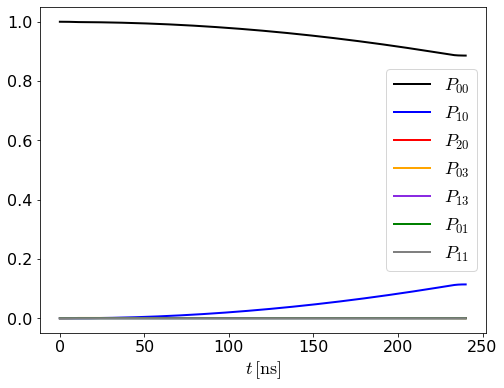

In [13]:
def prob_plot(
    tlist: np.ndarray, 
    probs: dict, 
    opt: dict={'fs': 18, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16}
) -> None:
    colors=['black', 'blue', 'red', 'orange', 'blueviolet', 'green', 'grey']
    levels = list(probs.keys())
    n_levels = len(levels)
    fig, ax = plt.subplots(figsize=(8, 6))
    for lev, k in zip(levels, range(n_levels)):
        ax.plot(tlist, probs[lev], linewidth=opt['lw'], 
                color=colors[k], label='$P_{' + lev + '}$')
    ax.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.tick_params(labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
prob_plot(tlist_eval, probs)  

We introduce the TomoEnv object. We also refine the absolute and relative tolerance of the qutip solver 

In [14]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-14
simu_opt.rtol = 1e-12

env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, 
                                      with_noise=False, dressed_noise=False)

The TomoEnv class can now return the superoperator representation of the quantum operation in an arbitrary Hilbert-Schmidt basis for a $d$-dimensional subspace, as long as this is a basis of diagonalizable operators. For instance the basis $|n \rangle \langle m|$, $n, m= 0, \dots, d-1$ is not a diagonalizable basis and thus the method cannot be used. 

In what follows we are interested in obtaining a superoperator representation of a quantum operation in the computational subspace that we here define

In [15]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

We remark that the specification of the subspace is left to the user and it has arbitrary dimension. The user must check that the given kets are indeed orthogonal. 

In what follows we will use the Weyl basis for qudits ($d>2$) as Hilbert-Schmidt basis. These are defined via the standard definition of $Z$ and $X$ operators for qudits (see Howard et al Nature volume 510, pages351–355 (2014)):

$$
Z | j \rangle= \omega^j | j \rangle,
$$
$$
X | j \rangle = | j + 1 \mod d \rangle,
$$
where $\omega = \exp \bigl[ \frac{2 \pi i}{d} \bigr ]$.

The (normalized) Weyl operators for qudits are defined as

$$
D(\boldsymbol{\xi})=D \bigl( \boldsymbol{\xi} = \begin{bmatrix}\xi_x & \xi_z 
\end{bmatrix}^T \bigr) = \frac{1}{\sqrt{d}} \omega^{- \frac{d+1}{2} \xi_x \xi_z} X^{\xi_x} Z^{\xi_z}, \quad \xi_x, \xi_z \in \mathbb{Z}_d = \{0, 1, \dots, d-1 \}.
$$
The Weyl operators form an orthonormal basis for the Hilbert space of (bounded) $d \times d$ matrices with Hilbert-Schmidt inner product

$$
\langle A, B \rangle = \mathrm{Tr}(A^{\dagger} B).
$$
In fact
$$
\langle D(\boldsymbol{\xi}), D(\boldsymbol{\xi}') \rangle = \delta_{\boldsymbol{\xi}, \boldsymbol{\xi}'}.
 $$

In order to use this basis to write our superoperator we simply need a function that orders them. Thus, this function should take as argument an index $i$ associated with the Weyl operator as well as the qudit dimension $d$ ($i < d^2$). The same is valid for any orthonormal Hilbert-Schmidt basis we wish to define, as long as it is a basis of diagonalizable matrices. 


We can easily obtain the superoperator in the Weyl basis. Notice that this gives information only within the defined computational subspace and not on the leakage subspace. Thus the following superoperator is complete knowledge of the states within the computational subspaces only if the leakage is zero. However, the following superoperator is the one needed to compute process fidelities as described in Eq. 8 of Wood-Gambetta Phys. Rev. A 97, 032306 (2018). The method to_super in the TomoEnv class is parallelized and we can specify the number of processes. 

In [17]:
n_process = 4

my_hs_basis = pauli_by_index

start = time.time()
sup_op = env_syst.to_super(comp_states_list, my_hs_basis, n_process, speed_up=True)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 193.586012840271 s


Notice how the superoperator can be obtained for any system and its operations are completely system agnostic.

We now use the previous superoperator to compute the process fidelity and average gate fidelity with respect to a $\mathrm{CZ}$ gate. First of all, we need to obtain the single-qubit gate corrections. This can be done directly from the superoperator via the following function.

In [18]:
sq_corr = util_tf_cr.single_qubit_corrections(sup_op, my_hs_basis)
sq_corr_sup = trf.kraus_to_super(sq_corr, my_hs_basis)
total_sup_op = sq_corr_sup.dot(sup_op)

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CZ}$ in the Weyl basis. This can be done via the function qutip.util.transformations.kraus_to_super

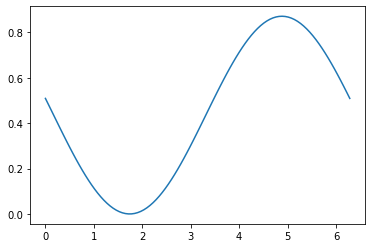

In [19]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

theta_list = list(np.linspace(0, 2*np.pi, 100))
fid_list = []
for theta in theta_list:
    cr_super = trf.kraus_to_super(cry(theta), my_hs_basis)
    fid_list.append(average_process_fidelity(cr_super, total_sup_op))

plt.plot(theta_list, fid_list)
plt.show()

We can now compute the process fidelity

In [20]:
cr_super_target = trf.kraus_to_super(cry(-np.pi/2), my_hs_basis)
f_pro = average_process_fidelity(cr_super_target, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>

Notice that this is by choice not done within the TomoEnv class, since the TomoEnv class should be agnostic of which gate we want to implement. Since during the gate also an unwanted $Y$ rotations is implemented let us try to virtually correct it. In particular, we look for the $Y$ rotation on the transmon that maximized the fidelity.

In [21]:
def ry_t(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

def ry_f(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(np.identity(2), rot_y)

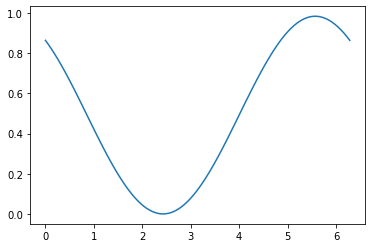

<IPython.core.display.Latex object>

In [22]:
fid_list_ry = []
for theta in theta_list:
    rot_y_super = trf.kraus_to_super(ry_t(theta), my_hs_basis)
    fid_list_ry.append(average_process_fidelity(cr_super_target, rot_y_super.dot(total_sup_op)))

fid_ry = np.array(fid_list_ry)

plt.plot(theta_list, fid_ry)
plt.show()
max_fid = np.max(fid_ry)
max_index = np.argmax(fid_ry)
sup_rot_y_opt = trf.kraus_to_super(ry_t(theta_list[max_index]), my_hs_basis)
display(Latex(r"Maximum achievable fidelity after ideal $Y$ rotations = ${}$".format(max_fid)))

The average leakage and seepage is instead computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively. 

In [23]:
avg_leakage = env_syst.leakage(comp_states_list)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

We observe that leakage is sensitive to whether we have a smooth rise time or not...

In [24]:
avg_seepage = env_syst.seepage(comp_states_list)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

<IPython.core.display.Latex object>

We can also check that with the selected accuracy of the qutip solver, for unitary dynamics (set loss tangents equal to zero) we reproduce the relation between leakage and seepage $d_1 L_1(\mathcal{E}) = d_2 L_2(\mathcal{E})$ ($d_1=4, d_2 = 11$)

In [25]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

<IPython.core.display.Latex object>

In [26]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

<IPython.core.display.Latex object>

Finally, the average gate fidelity is

In [27]:
total_sup_op_ry = sup_rot_y_opt.dot(total_sup_op)
f_gate = average_gate_fidelity(cr_super_target, total_sup_op_ry, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))


<IPython.core.display.Latex object>

It is clear that the main source of error is leakage. Let us thus check where the leakage is coming from mainly.

# Leakage analysis

To study leakage we consider the noiseless case

In [157]:
def run(
    time: np.ndarray,
    system: QubitSystem, 
    state_init: qtp.qobj.Qobj, 
    options: qtp.solver.Options=None
):
    hamil0 = system.hamiltonian(as_qobj=True)
    hamil_drive = []
    pulse_drive = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                hamil_drive.append(drive.hamiltonian(as_qobj=True))
                pulse_drive.append(drive.eval_pulse())
    jump_op = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
                    
    result = integrate(time, state_init, hamil0, hamil_drive,
                           pulse_drive, jump_op, "mesolve", options=options)
                    
    return result  

In [158]:
start = time.time()

_proj_comp = np.einsum('ai, aj -> ij', comp_states_list, np.conj(comp_states_list))
subsys_dims = list(q.dim_hilbert for q in coupled_sys)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)
res = run(time=2*np.pi*tlist, system=coupled_sys, state_init=proj_comp/d_comp, options=simu_opt)

end=time.time()
display(Latex(r'$\mathrm{{Leakage \, computation \, time}} = {:.3f} \, s$'.format(end - start)))
l1 = 1 - qtp.expect(proj_comp, res.states[-1])

<IPython.core.display.Latex object>

In [159]:
comp_state_label = ['00', '01', '10', '11']
leakage_states = []
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        if str(lev_t) + str(lev_f) not in comp_state_label:
            leakage_states.append(str(lev_t) + str(lev_f))

In [160]:
def get_probabilities(
    states_label: List[str], 
    system:QubitSystem, 
    final_state: qtp.qobj.Qobj
) -> Dict:
    prob = {}
    for label in states_label:
        ket = system.state(label, as_qobj=True)[1]
        projector = ket*ket.dag()
        prob[label] = qtp.expect(projector, final_state)
    return prob

In [161]:
leak_probs = get_probabilities(leakage_states, coupled_sys, res.states[-1])

display(Latex(r'$\mathrm{{Average\, Leakage \,}} L_1 = {:.7f} $'.format(l1)))

sum_leak = 0

for label in leakage_states:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, leak_probs[label])))
    sum_leak += leak_probs[label]
display(Latex(r'$\sum_k P_{{leak, k  }} = {:.7f}$'.format(sum_leak)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We notice that leakage is quite heterogeneous in the sense that many levels are a bit populated. I think this problem can be solved by several strategies such as optimizing the coupling, increasing the gate time or by taking larger frequency differences between the transmon and the higher levels of the fluxonium. Indeed, by reducing the coupling, at the price of a doubled gate time for fixed drive strength, we have much less leakage.